# NEU (Reconfigurations Map and Related Functions)

## Initializations:

In [94]:
# Deep Learning & ML
import re
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
from keras import backend as Kback
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
# import tkinter
# from tkinter import messagebox
import os as beepsnd

# General Outputs
print('TensorFlow:', tf.__version__)

TensorFlow: 2.1.0


In [2]:
#### TEMP

N_Reconfigurations = 10**1
d = 1 # Dimension of X
D = 1 # Dimension of Y

# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Epochs = 10**2


# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(x) #+ (x % 2)
%run Data_Generator.ipynb

<Figure size 640x480 with 1 Axes>

In [3]:
## TEM{}
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

## Helper Functions:

In [4]:
#----------------------------#
# Helper Functions T/F Functions
#----------------------------#
def bump_True(x):
    x_out = 1- tf.math.pow(tf.math.abs(x),2)
    x_out = tf.math.exp(-tf.math.divide(1,x_out))
    return x_out

def bump_False(x):
    x_out = 0
    return x_out

# Approximation to max(0,x) function by smooth function
# https://math.stackexchange.com/questions/517482/approximating-a-maximum-function-by-a-differentiable-function
def abs_helper(x):
    return tf.math.sqrt(tf.math.pow(x,2)+(10**(-5)))

def max_helper(x):
    return tf.math.multiply(abs_helper(x) + x,.5)

def soft_indicator(x):
    return max_helper(tf.math.sign(x))

def bump_function(x):
    # Gaussian rescaled to [-1,1]^d
    bump_out = 1-tf.math.pow(x,2)        
    bump_out = tf.math.divide(-1,bump_out)
    bump_out = tf.math.exp(bump_out)
    # Indicator
    indicator = soft_indicator(1-x)
    # 0 outside of [-1,1]^d
    bump_out = tf.math.multiply(bump_out,indicator)
    return bump_out

## Build Reconfiguration Unit
$$
x \mapsto \exp\left(
\psi(x-c;\sigma) X
\right) (x-c) + c
$$
where:
### Workflow
1. Shifts $x \in \mathbb{R}^d$ to $x- c$; c trainable.
2. Applies the map $\psi(x;\sigma)\triangleq e^{\frac{\sigma}{\sigma-|x|}}I_{\{|x|<\sigma\}}$ component-wise.  
3. Applies transformation $x \mapsto x +b$, $b \in \mathbb{R}^d$ trainable.
4. Applies the diagonalization map to that output: $ \left(x_1,\dots,x_d\right)\mapsto
                \begin{pmatrix}
                x_1 & & 0\\
                &\ddots &\\
                0 & & x_d\\
                \end{pmatrix}.$
5. Applies map $X \mapsto XA$, $A$ is a trainable $d\times d$ matrix.
6. Applies matrix exponential.
7. Multiplies output with result of (1).
8. Re-centers output to $x +c$ where $c$ is as in (1).

In [74]:
class Reconfiguration_unit_steps(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location = self.add_weight(name='location',
                                     shape=input_shape[1:],
                                     initializer='GlorotUniform',
                                     trainable=True)
#         self.scale = self.add_weight(name='location',
#                                     shape=input_shape[1:],
#                                     initializer='GlorotNormal',
#                                     trainable=True)
        
#        Step 3
#         self.threshold = self.add_weight(name='threshold',
#                             shape=input_shape[1:],
#                             initializer='GlorotUniform',
#                             trainable=True)
        

        # STEP 3 - NEW
        # INITIALIZE KERNELS
        self.kernel_a = self.add_weight(name='kernel_a ',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)

        #inverse width
        self.kernel_b = self.add_weight(name='kernel_b',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)

        #center
        self.kernel_c = self.add_weight(name='kernel_c',
                                    shape=input_shape[1:],
                                    initializer='zeros',
                                    trainable=True)
 

    
        ## Steps 4-9
        self.tangentbiases = self.add_weight(name='tangentbiases',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.tangentweights = self.add_weight(name='tangentweights',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
#         self.location_b = self.add_weight(name='location_b',
#                                     shape=input_shape[1:],
#                                     initializer='GlorotUniform',
#                                     trainable=True)
    
    
    def call(self, input):
        ### Steps 1-2
        # Relocated
        output_steps_1_2 = input + self.location
        # Rescaled
        #output_steps_1_2 = tf.math.multiply(tf.math.abs(self.scale),output_steps_1_2)
        
        ### Step 3
        # Old
#        output_step_3 = tf.math.multiply(output_steps_1_2,self.threshold)
#        output_step_3 = bump_function(output_step_3)    
        # NEW
        exp_arg = - self.kernel_b * tf.math.square(output_steps_1_2 - self.kernel_c)
        output_step_3 = self.kernel_a * tf.math.exp(exp_arg)
        
        ### Step 4-9
        x_out = tf.math.multiply(tf.math.abs(self.tangentweights),output_step_3) + self.tangentbiases
        
        # 7. Apply Matrix Exponential
        x_out = tf.linalg.diag(x_out)
        #------------------------------#
        # Using an approximation of the matrix exponential (tf.linalg.expm(x_out)) is prefeable 
        # **Since:** TF uses Sylvester's method to for (fast) computation but this requires additional assumptions on the matrix which are typically not satified...
        # **Instead:** Use a truncated power series representation (standard definition of expm) of order 4
        x_out = tf.linalg.diag(tf.ones(d+D)) + x_out + tf.linalg.matmul(x_out,x_out)/2 + tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))/6 +tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out)))/24 #+tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))))/120
        
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,input)
        
        # 9. Recenter Transformed Data
        output_steps_4_9 = x_out + self.location#_b
        
        # Return Output
        return output_steps_4_9

#### Projection Layer
Maps $\mathbb{X}\left((x,f(x))\mid \theta \right) \in \mathbb{R}^{d\times D}$ to an element of $\mathbb{R}^D$ by post-composing with the second canonical projection
$$
(x_1,x_2)\mapsto x_2
,
$$
where $x_1 \in \mathbb{R}^d$ and $x_2 \in \mathbb{R}^D$.  

In [75]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Fit and Compile First Reconfiguration Unit

Define function helper function fitting and compiling the basic model:

In [76]:
# define and fit the base model
def get_base_model(trainx, trainy):
    # Define Model
    #----------------#
    # Initialize
    input_layer = tf.keras.Input(shape=[d+D])
    # Apply Reconfiguration Unit
    reconfigure  = Reconfiguration_unit_steps()
    current_layer = reconfigure(input_layer)
    # Output
    output_layer = projection_layer(current_layer)
    reconfiguration_basic = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    # Compile Model
    #----------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile
    reconfiguration_basic.compile(loss = 'mse',
                    optimizer = optimizer_on,
                    metrics = ['mse'])
    
    # Fit Model
    #----------------#
    reconfiguration_basic.fit(trainx, trainy, epochs=100, verbose=0)
        
    # Return Output
    return reconfiguration_basic

Add and greedily train reconfiguration unit.

In [113]:
model = get_base_model(data_NEU,NEU_targets) #TEMP

In [165]:
# Dissasemble
layers = [l for l in model.layers]

# Define new reconfiguration unit to be added
new_reconfiguration_unit  = Reconfiguration_unit_steps()
current_layer_new = new_reconfiguration_unit(layers[len(layers)-2].output)

# Output Layer
output_layer_new = projection_layer(current_layer_new)

for i in range(len(layers)):
    layers[i].trainable = False



# build model
new_model = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
new_model.summary()

Model: "model_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_174 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
reconfiguration_unit_steps_1 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_1 (None, 2)                 12        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 24
Trainable params: 12
Non-trainable params: 12
_________________________________________________________________


In [9]:
def add_reconfiguration_unit_greedily(model, trainx, trainy):

    # Remove the output (Lambda/projection) layer
    model._layers.pop()

    # mark all remaining layers as non-trainable
    for layer in model._layers:
        layer._trainable = False

#     # Apply Reconfiguration Unit
#     input_layer = tf.keras.Input(shape=[d+D])
#     # Apply Reconfiguration Unit
#     reconfigure  = Reconfiguration_unit_steps()
#     current_layer = reconfigure(input_layer)

#     # Output
#     model_new = model(current_layer)
#     output_layer = projection_layer(model_new)
    
    
    # Changing order attempt...
    
 
    # Apply Reconfiguration Unit
    input_layer2 = tf.keras.Input(shape=[d+D])
    reconfigure  = Reconfiguration_unit_steps()
    current_layer = reconfigure(input_layer2)
    # Output
    output_layer = projection_layer(current_layer)
    # Build Model
    model_new_temp = tf.keras.Model(inputs = [input_layer2],outputs = output_layer)
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile Model
    model_new_temp.compile(loss = 'mse',
                    optimizer = optimizer_on,
                    metrics = ['mse'])
    
    
    
    # Combine Models
    # Apply Reconfiguration Unit
    input_layer = tf.keras.Input(shape=[d+D])
    # Apply Reconfiguration Unit
    current_layer = model(input_layer)
    # Output
    current_layer = model_new_temp(current_layer)
    output_layer = projection_layer(current_layer)
    
    model_new = tf.keras.Model(inputs = [input_layer],outputs = output_layer)

    
    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile Model
    model_new.compile(loss = 'mse',
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    model_new.fit(trainx, trainy, epochs=100, verbose=0)
    # model.summary()
    
    # Return Output
    return model_new

In [13]:
model = get_base_model(data_NEU,NEU_targets)

# Predict
NEU_prediction = model.predict(data_NEU)

In [17]:
# Initialize Deep Model
model1 = model

# Build Deep Model
#for i in range(N_Reconfigurations):
model1 = add_reconfiguration_unit_greedily(model1,data_NEU,NEU_targets)

# Summarize Deep Model
model1.summary()

# Predict with Deep Model (Greedy Implementation)
NEU_prediction1 = model1.predict(data_NEU)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
reconfiguration_unit_steps_4 (None, 2)                 8         
_________________________________________________________________
model_1 (Model)              (None, 1)                 0         
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


HERE!!!
https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/

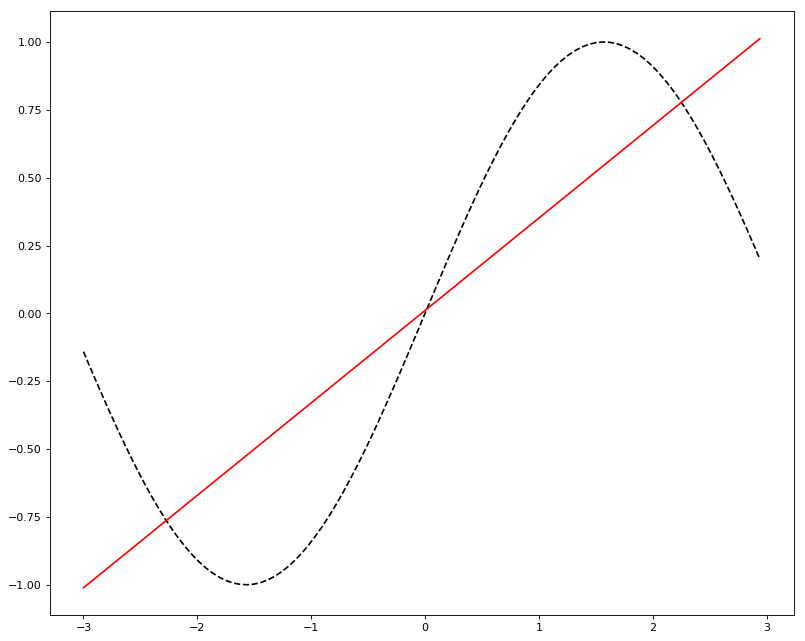

In [18]:
# import matplotlib.pyplot as plt
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Plot Models
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')
plt.plot(data_x,NEU_prediction,color='b',label='NEU-OLS')
plt.plot(data_x,NEU_prediction1,color='g',label='NEU-OLS')
plt.plot(data_x,model_pred_y,color='r',label='NEU-OLS')